# Variational Autoencoder

In [80]:
import numpy as np
from sklearn import preprocessing

## generate random data

In [81]:
# matrixSize = 5

# A = np.random.rand(mean, matrixSize) * 2 
# B = np.dot(A, A.transpose())
# print(B)
# print(B.shape)

In [82]:
mean = np.array([20, 30, 50, 30, 40])
print(mean.shape)
# mean = [0, 0,0,0,0]
cov = [[1, 0,0,0,0], [0, 100,0,0,0],[0, 0,2,0,0],[0, 0,0,5,0],[0, 0,0,0,10]]  # diagonal covariance

# cov = B.copy()
# print(cov.shape)
dataset = np.random.multivariate_normal(mean, cov, 10000)
dataset = dataset.astype(np.float32)
print(dataset)
dim = dataset.shape[1]
print(dataset.shape)

(5,)
[[21.801596 34.80108  47.673626 33.566742 42.394382]
 [21.269262 26.057415 48.982178 28.588125 38.910076]
 [19.991621 12.217057 47.049393 30.544426 39.12916 ]
 ...
 [19.697912 15.696453 48.286747 29.615541 36.350266]
 [20.166105 53.532597 50.954185 29.617931 38.83624 ]
 [19.477797 23.756226 53.03234  27.627663 40.353233]]
(10000, 5)


In [83]:
# dataset = preprocessing.normalize(dataset, axis=1)
# print(dataset[0,:])

## Model

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms

In [85]:
class VAE(nn.Module):
    def __init__(self, zdim, input_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, 20)
        self.fc21 = nn.Linear(20, zdim) 
        self.fc22 = nn.Linear(20, zdim) 
        self.fc3 = nn.Linear(zdim, 20)
        self.fc4 = nn.Linear(20, input_dim)
        self.input_dim = input_dim
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn(mu.size(0),mu.size(1)) # assume eps normally distributed ~N(0,1)
#             eps = torch.randn_like(std)
            z = mu+ eps*std
#             return eps.mul(std).add_(mu)
            return z
#         else:
#             return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [86]:
def bce_loss(y_pred, y_true, input_dim):
#     print(y_pred)
#     print(y_true.view(-1, input_dim))
    BCE = F.binary_cross_entropy(y_pred, y_true.view(-1, input_dim), reduction='sum')
    return BCE

def mse_loss(y_pred, y_true):
    loss = nn.MSELoss(reduction='sum', size_average=False)
    return loss(y_pred, y_true)

def kld_Loss(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true, input_dim):
    recon_x, mu, logvar = y_pred
    x = y_true


    KLD = kld_Loss(mu, logvar)

    MSE = mse_loss(recon_x, x)
    return KLD + MSE


In [87]:
def train(model, num_epochs = 1, batch_size = 64, learning_rate = 0.0002):
    model.train() #train mode
    torch.manual_seed(42)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    optimizer = optim.Adam(model.parameters(), learning_rate)
    
    for epoch in range(num_epochs):
      for data in train_loader:  # load batch
#           print(data)
          
          reconmulogvar = model(data)
          loss = loss_function(reconmulogvar, data, 5) # calculate loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      
      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

In [88]:
batch_size = 256

model = VAE(5, 5)
train(model, num_epochs = 1000, batch_size = batch_size, learning_rate = 0.01)

Epoch:1, Loss:73697.3672
Epoch:2, Loss:20059.2617
Epoch:3, Loss:12205.1963
Epoch:4, Loss:8285.8887
Epoch:5, Loss:6635.8086
Epoch:6, Loss:5311.6934
Epoch:7, Loss:4177.0146
Epoch:8, Loss:3698.5950
Epoch:9, Loss:3721.5718
Epoch:10, Loss:2999.0259
Epoch:11, Loss:2678.3633
Epoch:12, Loss:2404.2500
Epoch:13, Loss:2278.1304
Epoch:14, Loss:2034.8296
Epoch:15, Loss:2003.3621
Epoch:16, Loss:1413.2329
Epoch:17, Loss:1612.7629
Epoch:18, Loss:1228.8235
Epoch:19, Loss:1736.4645
Epoch:20, Loss:1501.4418
Epoch:21, Loss:1179.7429
Epoch:22, Loss:1300.3638
Epoch:23, Loss:1229.1814
Epoch:24, Loss:1222.1516
Epoch:25, Loss:1128.4382
Epoch:26, Loss:1099.6647
Epoch:27, Loss:1119.9277
Epoch:28, Loss:1060.5632
Epoch:29, Loss:1111.0129
Epoch:30, Loss:903.7620
Epoch:31, Loss:948.8634
Epoch:32, Loss:861.0576
Epoch:33, Loss:818.2700
Epoch:34, Loss:915.1267
Epoch:35, Loss:719.7092
Epoch:36, Loss:782.5737
Epoch:37, Loss:815.2282
Epoch:38, Loss:763.2162
Epoch:39, Loss:795.0417
Epoch:40, Loss:790.0677
Epoch:41, Loss:75

Epoch:333, Loss:228.8647
Epoch:334, Loss:192.6931
Epoch:335, Loss:239.8956
Epoch:336, Loss:193.9992
Epoch:337, Loss:182.9382
Epoch:338, Loss:219.3965
Epoch:339, Loss:218.2997
Epoch:340, Loss:213.5616
Epoch:341, Loss:185.1936
Epoch:342, Loss:176.4085
Epoch:343, Loss:206.7819
Epoch:344, Loss:188.1598
Epoch:345, Loss:204.9632
Epoch:346, Loss:198.1783
Epoch:347, Loss:180.3996
Epoch:348, Loss:207.6035
Epoch:349, Loss:213.4399
Epoch:350, Loss:196.1685
Epoch:351, Loss:179.3149
Epoch:352, Loss:185.7215
Epoch:353, Loss:202.0022
Epoch:354, Loss:196.4680
Epoch:355, Loss:230.2006
Epoch:356, Loss:191.4930
Epoch:357, Loss:188.6804
Epoch:358, Loss:201.9117
Epoch:359, Loss:189.2840
Epoch:360, Loss:216.9488
Epoch:361, Loss:217.6987
Epoch:362, Loss:204.5789
Epoch:363, Loss:212.2246
Epoch:364, Loss:185.8052
Epoch:365, Loss:195.3882
Epoch:366, Loss:191.5003
Epoch:367, Loss:206.1038
Epoch:368, Loss:207.6435
Epoch:369, Loss:203.6947
Epoch:370, Loss:181.8996
Epoch:371, Loss:208.6374
Epoch:372, Loss:193.3965


Epoch:662, Loss:161.1937
Epoch:663, Loss:157.4667
Epoch:664, Loss:155.1888
Epoch:665, Loss:163.6838
Epoch:666, Loss:168.0952
Epoch:667, Loss:166.7646
Epoch:668, Loss:158.5628
Epoch:669, Loss:178.8103
Epoch:670, Loss:157.9310
Epoch:671, Loss:157.5083
Epoch:672, Loss:161.8026
Epoch:673, Loss:189.5738
Epoch:674, Loss:149.9313
Epoch:675, Loss:160.2472
Epoch:676, Loss:158.1436
Epoch:677, Loss:159.9577
Epoch:678, Loss:160.9387
Epoch:679, Loss:160.0195
Epoch:680, Loss:138.8847
Epoch:681, Loss:172.7494
Epoch:682, Loss:164.2675
Epoch:683, Loss:149.1451
Epoch:684, Loss:154.0811
Epoch:685, Loss:156.0966
Epoch:686, Loss:135.5020
Epoch:687, Loss:157.9817
Epoch:688, Loss:158.6146
Epoch:689, Loss:158.4518
Epoch:690, Loss:151.8085
Epoch:691, Loss:179.6204
Epoch:692, Loss:162.3050
Epoch:693, Loss:156.1876
Epoch:694, Loss:140.6408
Epoch:695, Loss:179.6843
Epoch:696, Loss:155.7227
Epoch:697, Loss:152.2598
Epoch:698, Loss:134.5836
Epoch:699, Loss:178.9906
Epoch:700, Loss:145.2104
Epoch:701, Loss:148.6228


Epoch:990, Loss:150.2663
Epoch:991, Loss:154.0675
Epoch:992, Loss:168.3483
Epoch:993, Loss:136.7874
Epoch:994, Loss:145.5515
Epoch:995, Loss:143.7822
Epoch:996, Loss:155.2189
Epoch:997, Loss:136.8757
Epoch:998, Loss:138.6930
Epoch:999, Loss:151.0750
Epoch:1000, Loss:140.4019


In [89]:
result = []
for i in range(2000):
  rinpt = torch.randn(1, 5)
  with torch.no_grad():
    si = model.decode(rinpt).numpy()
  result.append(si)

In [90]:

def get_most_similar_besides_i(simulated_data, test):
    min_idx = 100000
    min_distance = 1000000
    point2 = test
    for idx in range(len(simulated_data)):
        si = simulated_data[idx][0]
        distance = np.linalg.norm(si[:4] - point2[:4])
    #     print(distance)
        if distance < min_distance:
#             print(distance)
            min_idx = idx
            min_distance = distance
    return min_idx

In [91]:
result[504][0]

array([20.496897, 39.614094, 48.877445, 28.373152, 43.028202],
      dtype=float32)

In [92]:
dataset[0,:]

array([21.801596, 34.80108 , 47.673626, 33.566742, 42.394382],
      dtype=float32)

In [93]:
testing_dataset = np.random.multivariate_normal(mean, cov, 3000)
testing_dataset = testing_dataset.astype(np.float32)

In [94]:
testing_dataset

array([[20.962698, 35.187637, 48.596985, 29.810362, 45.58738 ],
       [19.507748, 44.058628, 47.635754, 29.370222, 37.8773  ],
       [18.67512 , 27.517698, 48.11171 , 29.784754, 41.302452],
       ...,
       [18.900017, 31.227945, 50.796642, 31.075499, 43.5956  ],
       [19.877048, 45.66413 , 49.7807  , 26.217026, 43.415073],
       [16.682652, 29.177496, 52.07002 , 28.970936, 38.10998 ]],
      dtype=float32)

In [95]:
mean = np.array([20, 30, 50, 30, 40])

In [96]:
get_most_similar_besides_i(result, testing_dataset[1])

1718

In [97]:
# for i in range(testing_dataset.shape[0]):
#     idx = get_most_similar_besides_i(result, testing_dataset[i])
#     print(testing_dataset[i], endx="\t")
#     print(result[idx])

TypeError: 'endx' is an invalid keyword argument for print()

In [98]:
# testing dataset shape
result_new = np.array(result)[:,0,:]
result_new.shape

(2000, 5)

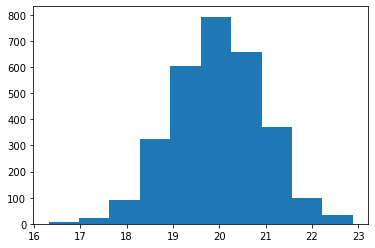

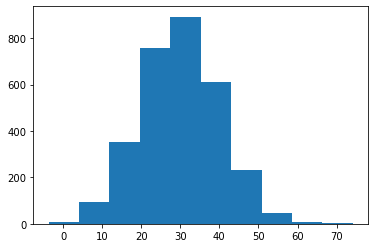

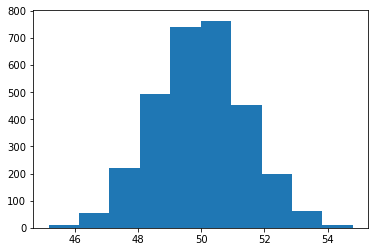

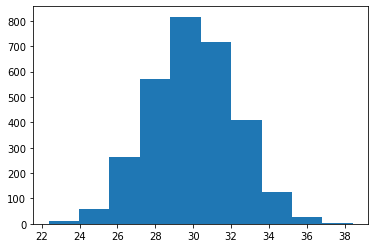

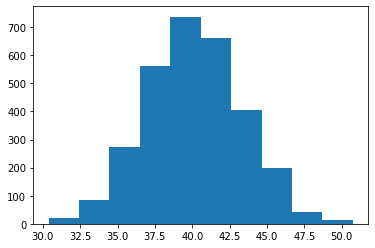

In [99]:
import matplotlib.pyplot as plt

plt.hist(testing_dataset[:,0])
plt.show()
plt.hist(testing_dataset[:,1])
plt.show()
plt.hist(testing_dataset[:,2])
plt.show()
plt.hist(testing_dataset[:,3])
plt.show()
plt.hist(testing_dataset[:,4])
plt.show()

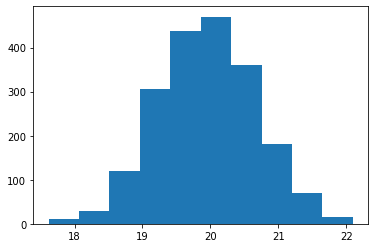

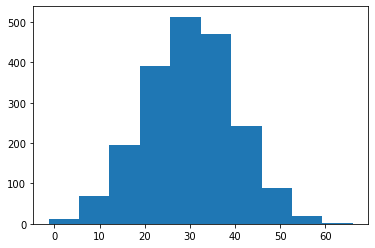

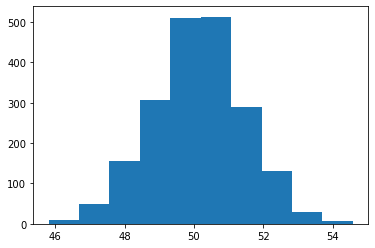

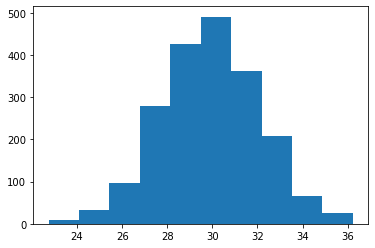

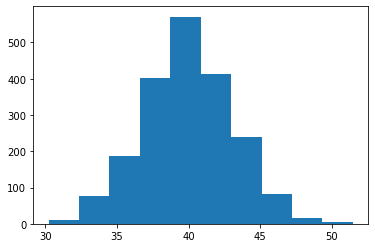

In [100]:
plt.hist(result_new[:,0])
plt.show()
plt.hist(result_new[:,1])
plt.show()
plt.hist(result_new[:,2])
plt.show()
plt.hist(result_new[:,3])
plt.show()
plt.hist(result_new[:,4])
plt.show()

In [114]:
var_0 = result_new[:,0].var()
mean_0 = result_new[:,0].mean()
var_1 = result_new[:,1].var()
mean_1 = result_new[:,1].mean()
var_2 = result_new[:,2].var()
mean_2 = result_new[:,2].mean()
var_3 = result_new[:,3].var()
mean_3 = result_new[:,3].mean()
var_4 = result_new[:,4].var()
mean_4 = result_new[:,4].mean()
result_mean = [mean_0, mean_1, mean_2, mean_3, mean_4]
result_var = [var_0, var_1, var_2, var_3, var_4]

In [102]:
def kl_divergence(mean1, var1, mean2, var2):
    return np.log(var2/var1) + (var1 ** 2 + (mean1 - mean2) ** 2) / (2 * var2 ** 2) - 1/2

In [115]:

for i in range(5):
    kl = kl_divergence(mean1=result_mean[i], # generated data mean
                  var1=result_var[i],        # generated data variance
                  mean2=mean[i],             # train data mean
                  var2=cov[i][i])            # train data variance
    print("for dim {}, the kl divergence is {}".format(i, kl))

for dim 0, the kl divergence is 0.2894043071800104
for dim 1, the kl divergence is 5.74446632581882e-05
for dim 2, the kl divergence is 0.02259205161455191
for dim 3, the kl divergence is 0.0015532017132954268
for dim 4, the kl divergence is 0.0004644006645078136


100

In [ ]:
# ignore bellow

In [ ]:
class VAE2(nn.Module):
    def __init__(self, zdim, input_dim):
        super(VAE2, self).__init__()

        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc21 = nn.Linear(20, zdim)
        self.fc22 = nn.Linear(20, zdim)
        self.fc3 = nn.Linear(zdim, 20)
        self.fc33 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, input_dim)
        self.input_dim = input_dim
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn(mu.size(0),mu.size(1)) # assume eps normally distributed ~N(0,1)
#             eps = torch.randn_like(std)
            z = mu+ eps*std
#             return eps.mul(std).add_(mu)
            return z
#         else:
#             return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h33 = F.relu(self.fc33(h3))
        return self.fc4(h33)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
batch_size = 128

model = VAE2(5, 5)
train(model, num_epochs = 300, batch_size = batch_size, learning_rate = 0.05)

In [ ]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]  # diagonal covariance

In [ ]:
import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()